In [1]:
import logging
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

logging.basicConfig(level=logging.INFO)

In [ ]:
import torch
torch.__version__

# Finetuning Zoobot for Galaxy Classification (Galaxy MNIST data)

## Install Zoobot

In [ ]:
# Clean up old directories(Prevents file conflicts from previous runs)
!rm -rf /content/zoobot

In [ ]:
!git clone --branch dev https://github.com/mwalmsley/zoobot.git

In [ ]:
# Clean up old directories(Prevents file conflicts from previous runs)
!rm -rf /content/galaxy-datasets

In [ ]:
!git clone https://github.com/mwalmsley/galaxy-datasets.git

In [ ]:
!pip install -e /content/galaxy-datasets

In [ ]:
!pip install -e /content/zoobot[pytorch-colab]

In [ ]:
# --- Python path fix ---
# This ensures the Python interpreter can find the zoobot and galaxy_datasets modules.
sys.path.append('/content/galaxy-datasets')
sys.path.append('/content/zoobot')
sys.path.append('/content/zoobot/pytorch')
print("Environment setup complete. Ready to import.")

Environment setup complete. Ready to import.


## Download Catalogs of Images and Labels

In [ ]:
from galaxy_datasets import galaxy_mnist # Import the Galaxy MNIST dataset

data_dir = '/content/galaxy_mnist'
print("Downloading and loading GalaxyMNIST training catalog...")
train_catalog, _ = galaxy_mnist(
    root=data_dir,
    download=True,
    train=True
    )
print("Loading GalaxyMNIST test catalog...")
test_catalog, _ = galaxy_mnist(
    root=data_dir,
    download=True,
    train=False
    )

train_catalog.head()

In [13]:
# Identify the train_catalog columns
train_catalog.columns

Index(['id_str', 'label', 'filename', 'file_loc'], dtype='object')

In [14]:
# Create the single-item list containing the column name
label_cols = ['label']
# Check the actual column in the catalog
train_catalog['label']

,label
0,1
1,1
2,3
3,1
4,3
...,...
7995,3
7996,3
7997,3
7998,2


In [19]:
# Hyperparameters
BATCH_SIZE = 64         # Optimized for GPU speed
NUM_WORKERS = 2         # Stable number for Colab CPU
N_CLASSES = 4           # GalaxyMNIST (four-class)
MAX_EPOCHS = 30         # Maximum limit for training
LEARNING_RATE = 1e-5    # Standard low learning rate for fine-tuning

In [21]:
# --- Initiate the DataModule
# Note: The 'catalog' argument uses the full train_catalog and performs the internal train/val split.
from galaxy_datasets.pytorch.galaxy_datamodule import CatalogDataModule
from galaxy_datasets.transforms import get_galaxy_transform, default_view_config

datamodule = CatalogDataModule(
  label_cols=label_cols,              # specifying which columns to load as labels with `label_cols`
  catalog=train_catalog,              # Passes the full catalog DataFrame
  batch_size=BATCH_SIZE,              # Defines the number of samples processed per iteration
  num_workers=NUM_WORKERS,            # sets the parallelism for loading data
  train_transform=get_galaxy_transform(default_view_config()),  # Defines augmentations applied only to the training set.
  test_transform=get_galaxy_transform(default_view_config())    # Defines non-augmenting transformations for validation/test sets.
)
# --- Final Setup ---
# Prepare data
datamodule.prepare_data()
# Finalize setup:
#    a) Splits the 'catalog' into TRAIN and VALIDATION datasets (e.g., 80/20 split).
#    b) Converts the catalogs into PyTorch Dataset objects and creates the DataLoaders.
datamodule.setup()

print("CatalogDataModule setup complete.")

CatalogDataModule setup complete.


In [22]:
# Demonstrate the contents and shape of the first batch loaded for training.
# This confirms the images are transformed into PyTorch Tensors and the labels are correctly indexed.
datamodule.setup()
for batch in datamodule.train_dataloader():
  images = batch['image']
  labels = batch['label']
  print(images.min(), images.max(), images.shape)
  print(labels)
  break

tensor(0.) tensor(1.) torch.Size([64, 3, 224, 224])
tensor([1, 3, 1, 0, 2, 1, 2, 2, 2, 3, 0, 3, 3, 2, 0, 1, 3, 2, 2, 1, 1, 0, 2, 0,
        2, 0, 0, 2, 2, 3, 0, 0, 1, 1, 2, 2, 1, 3, 1, 0, 0, 1, 3, 3, 0, 2, 1, 2,
        2, 2, 1, 0, 0, 0, 0, 0, 0, 3, 3, 3, 2, 0, 0, 0])


## Download Pretrained Model

In [ ]:
# --- Model Initiation ---
from zoobot.pytorch.training.finetune import FinetuneableZoobotClassifier

# Note: The FinetuneableZoobotClassifier is a powerful wrapper that downloads the pre-trained weights,
# automatically freezes the necessary base layers, and attaches the new classification head layer.
model = FinetuneableZoobotClassifier(
    # Arguments for FinetuneableZoobotClassifier
    label_col=label_cols[0],          # Important: Tells the model the name of the single column ('label')
                                      # containing the class index (0, 1, 2, or 3).
    name='mwalmsley/convnext_nano',   # Specifies the name of the pre-trained Zoobot backbone to download, in this case convnext_nano.
    learning_rate=LEARNING_RATE,      # Uses the low learning rate (1e-5) required for stable fine-tuning.
    num_classes=N_CLASSES,            # Defines the size of the new output/head layer (4 neurons for the 4 classes).
)
print("Model initiation complete.")

# Finetuning Zoobot

In [ ]:
# Trainer Setup and Execution
from zoobot.pytorch.training.finetune import get_trainer

save_dir = os.path.join('/content', 'zoobot_classifier_results', 'finetune_epoch_30')
# Use the working get_trainer utility for PyTorch Lightning setup:
trainer = get_trainer(
    save_dir,
    accelerator='cuda',  # Ensures training runs on GPU
    devices=1,
    max_epochs=30
    )
# --- Training Execution ---
print(f"Starting GPU Fine-Tuning for {trainer.max_epochs} epochs...")
trainer.fit(model, datamodule)
print("Test run complete! Reached maximum epochs.")



In [ ]:
# --- Load the best checkpoint & Make predictions ---
best_checkpoint = trainer.checkpoint_callback.best_model_path
finetuned_model = FinetuneableZoobotClassifier.load_from_checkpoint(best_checkpoint)

In [28]:
# --- Final Class Mapping for Analysis ---
# Defines the order of classes (index 0, 1, 2, 3) for reference.
OFFICIAL_CLASS_ORDER = [
    "smooth_round",
    "smooth_cigar",
    "edge_on_disk",
    "unbarred_spiral"
]

# The output CSV needs columns for the probability of each class
CLASSIFICATION_OUTPUT_COLS = [f'p_{name}' for name in OFFICIAL_CLASS_ORDER]
# Result: ['p_smooth_round', 'p_smooth_cigar', 'p_edge_on_disk', 'p_unbarred_spiral']
# Define csv path
FINAL_CSV_LOC = os.path.join(save_dir, 'finetuned_predictions.csv')
print(f"Predictions will be saved to {FINAL_CSV_LOC}")

Predictions will be saved to /content/zoobot_classifier_results/finetune_epoch_30/finetuned_predictions.csv


In [ ]:
# --- Prediction ---
from zoobot.pytorch.predictions import predict_on_catalog
from galaxy_datasets.transforms import minimal_view_config

# Define the non-augmenting transform object used for prediction inference.
# Note: minimal_view_config ensures no random augmentation is applied during testing.
inference_transform = get_galaxy_transform(minimal_view_config())

_ = predict_on_catalog.predict(
  catalog=test_catalog,
  model=finetuned_model,
  inference_transform = inference_transform, # get_galaxy_transform is already imported in a cell above
  label_cols=CLASSIFICATION_OUTPUT_COLS,     # Specifies the four output column names for the CSV
  save_loc=FINAL_CSV_LOC,
  trainer_kwargs={'accelerator': 'gpu', 'devices': 'auto'},
  datamodule_kwargs={'num_workers': 1}
)
print("Prediction complete! Results are ready for analysis.")

In [30]:
# Join predicted probabilities with ground truth
predictions = pd.read_csv(FINAL_CSV_LOC)

# Join predicted probabilities (from the CSV) with the essential ground truth data
# (image path and true label) from the original test_catalog.
# This merge uses 'id_str' as the unique key to align the model's output with the correct answers.
predictions = pd.merge(
    predictions,
    test_catalog[['id_str', 'file_loc', 'label']],
    on='id_str',
    how='left' # Keeps all rows from the predictions table (the left table)
)

predictions.head()

,p_smooth_round,p_smooth_cigar,p_edge_on_disk,p_unbarred_spiral,id_str,file_loc,label
0,0.002106,0.056751,0.934703,0.006440,test_galaxy_0,/content/galaxy_mnist/images/test_galaxy_0.jpg,3
1,0.000082,0.001344,0.998544,0.000031,test_galaxy_1,/content/galaxy_mnist/images/test_galaxy_1.jpg,2
2,0.000281,0.807686,0.191793,0.000240,test_galaxy_2,/content/galaxy_mnist/images/test_galaxy_2.jpg,1
3,0.000069,0.000007,0.000247,0.999676,test_galaxy_3,/content/galaxy_mnist/images/test_galaxy_3.jpg,3
4,0.991985,0.001649,0.005797,0.000569,test_galaxy_4,/content/galaxy_mnist/images/test_galaxy_4.jpg,0


In [31]:
# Print all columns starting with 'p_' in the loaded predictions DataFrame for a check
actual_prob_cols = [col for col in predictions.columns if col.startswith('p_')]
print("Actual Probability Columns Saved by Model:")
print(actual_prob_cols)

Actual Probability Columns Saved by Model:
['p_smooth_round', 'p_smooth_cigar', 'p_edge_on_disk', 'p_unbarred_spiral']


In [32]:
# --- Calculate Predicted Index and Clean Data ---

import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd

# --- Finalized Configuration (Matching the training and prediction outputs) ---
OFFICIAL_CLASS_ORDER = ["smooth_round", "smooth_cigar", "edge_on_disk", "unbarred_spiral"]
prediction_columns = ['p_smooth_round', 'p_smooth_cigar', 'p_edge_on_disk', 'p_unbarred_spiral']

# 1. Find the predicted column name (e.g., 'p_smooth_round')
predictions['predicted_name'] = predictions[prediction_columns].idxmax(axis=1)

# 2. Build the mapping dictionary with the full column names
# The dictionary is defined here:
PREDICTION_NAME_TO_INDEX = {name: i for i, name in enumerate(prediction_columns)}
# Result: {'p_smooth_round': 0, 'p_smooth_cigar': 1, 'p_edge_on_disk': 2, 'p_unbarred_spiral': 3}

# 3. Convert the predicted column NAME back into the integer index (0, 1, 2, 3)
# This uses the dictionary defined above (PREDICTION_NAME_TO_INDEX)
predictions['predicted_index'] = predictions['predicted_name'].map(PREDICTION_NAME_TO_INDEX)

# 4. Remove any rows where prediction failed
predictions_cleaned = predictions.dropna(subset=['predicted_index'])

# 5. Convert the predicted index to an integer type
predictions_cleaned['predicted_index'] = predictions_cleaned['predicted_index'].astype(int)

print(f"Data cleaned. Used {len(predictions_cleaned)} of {len(predictions)} rows for analysis.")

Data cleaned. Used 2000 of 2000 rows for analysis.


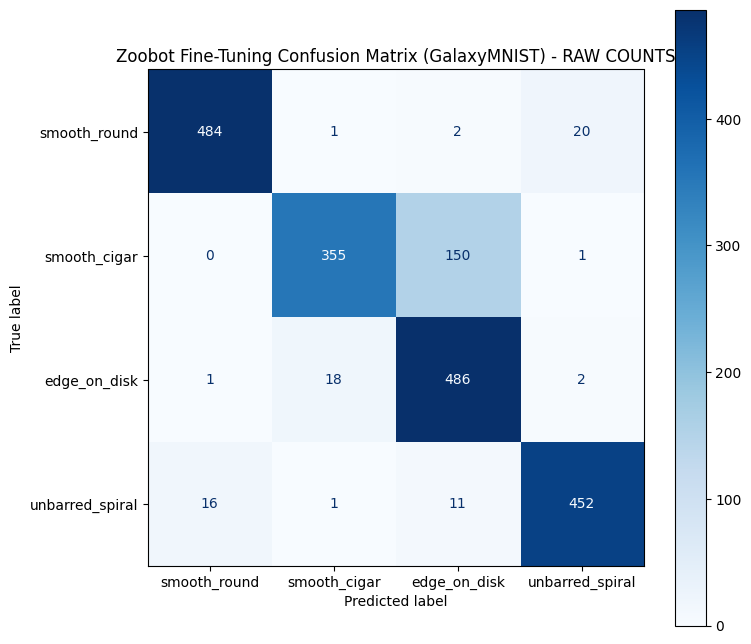

In [33]:
# --- Generate and Plot the Confusion Matrix ---

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Re-calculate the raw matrix (cm)
cm = confusion_matrix(
    y_true=predictions_cleaned['label'],
    y_pred=predictions_cleaned['predicted_index'],
    labels=np.arange(len(OFFICIAL_CLASS_ORDER))
)

# Plot the matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=OFFICIAL_CLASS_ORDER
)

# CRITICAL FIX: Plot the RAW COUNTS (using 'd' format for integer display)
disp.plot(cmap=plt.cm.Blues,
          values_format='d',  # 'd' stands for integer format (raw counts)
          ax=ax)

plt.title('Zoobot Fine-Tuning Confusion Matrix (GalaxyMNIST) - RAW COUNTS')
plt.show()


In [41]:
# --- OVERALL ACCURACY CALCULATION ---
# The accuracy is the sum of the diagonal (correct predictions)
# divided by the sum of all elements (total predictions).

overall_accuracy = np.trace(cm) / np.sum(cm)
print(f"Overall Classification Accuracy: {overall_accuracy:.4f}")

Overall Classification Accuracy: 0.8885


In [35]:
# --- Configuration (Add String Labels for Visualization) ---

# Create a mapping dictionary from index to name (e.g., 0 -> 'smooth_round')
INDEX_TO_NAME = {i: name for i, name in enumerate(OFFICIAL_CLASS_ORDER)}

# 1. Add the predicted class name (e.g., 'smooth_cigar')
predictions['predicted_name_str'] = predictions['predicted_index'].map(INDEX_TO_NAME)

# 2. Add the true class name (e.g., 'edge_on_disk')
predictions['true_name_str'] = predictions['label'].map(INDEX_TO_NAME)
print("String label columns added to predictions DataFrame.")

String label columns added to predictions DataFrame.


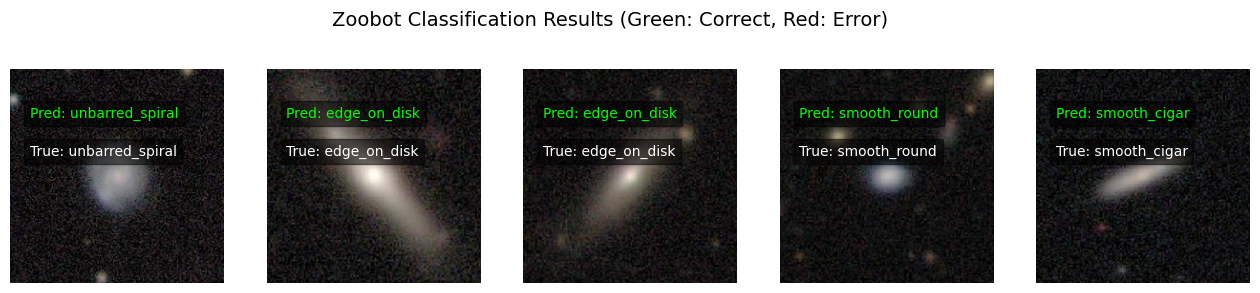

In [45]:
# Final Visualization Function
from PIL import Image
import matplotlib.pyplot as plt

def show_classification_results(df):
    """
    Displays the first 5 galaxies in the DataFrame along with their
    predicted and true classification labels.
    """
    fig, axes = plt.subplots(ncols=5, figsize=(16, 3))

    for n in range(5):
        galaxy = df.iloc[n]

        # Use the file location column from the merged DataFrame
        im = Image.open(galaxy['file_loc'])
        axes[n].imshow(im)

        color = 'lime' if galaxy['predicted_name_str'] == galaxy['true_name_str'] else 'red'

        axes[n].text(20, 50, f"Pred: {galaxy['predicted_name_str']}",
                     color=color, fontsize=10,
                     bbox=dict(facecolor='black', alpha=0.5))

        axes[n].text(20, 90, f"True: {galaxy['true_name_str']}",
                     color='white', fontsize=10,
                     bbox=dict(facecolor='black', alpha=0.5))

        axes[n].axis('off')

    plt.suptitle("Zoobot Classification Results (Green: Correct, Red: Error)", fontsize=14, y=1.05)
    plt.show()
# --- Show Correct or Incorrect predictions ---
# 1. To show random correct predictions:
show_classification_results(predictions[predictions['predicted_index'] == predictions['label']].sample(5, random_state=42))

# 2. To show random errors (if enough exist):
#show_classification_results(predictions[predictions['predicted_index'] != predictions['label']].sample(5, random_state=42))

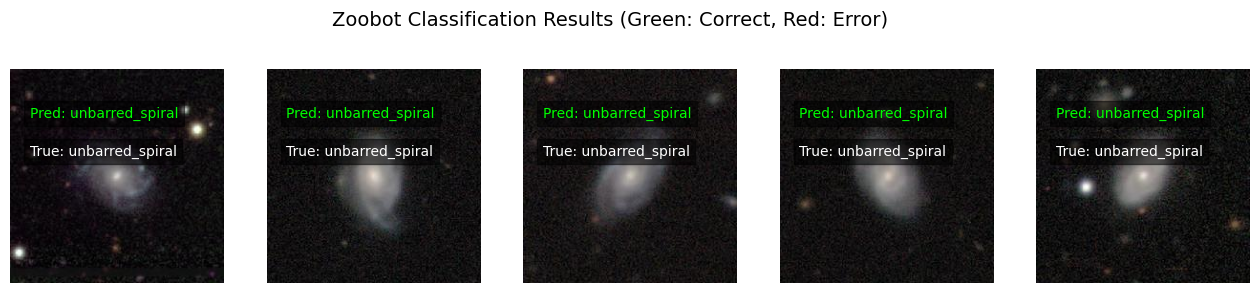

In [46]:
# --- Top 5 Predictions ---

# Calculate the maximum probability across the four columns for each galaxy
predictions['max_confidence'] = predictions[prediction_columns].max(axis=1)

# 1. Sort the DataFrame by the highest confidence, descending
top_5_predictions = predictions.sort_values('max_confidence', ascending=False).head(5)

# 2. Run the established visualization function on the top 5
show_classification_results(top_5_predictions)

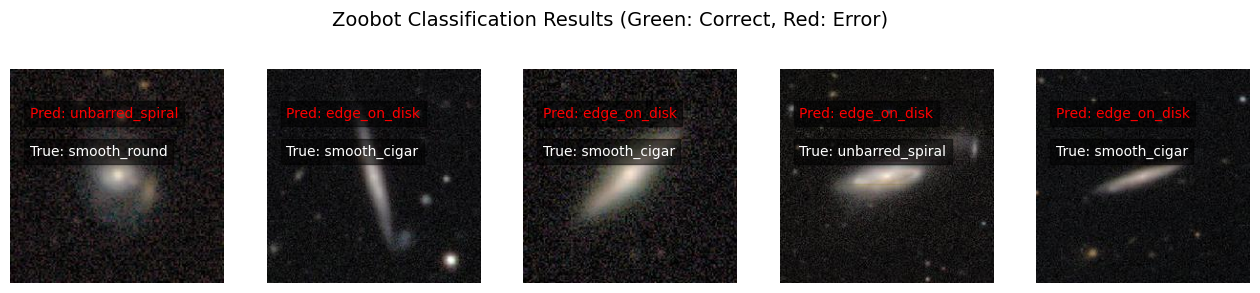


Max Confidence Scores for Top 5 Errors:
        true_name_str predicted_name_str  max_confidence
106      smooth_round    unbarred_spiral        0.999100
1850     smooth_cigar       edge_on_disk        0.996470
412      smooth_cigar       edge_on_disk        0.992146
1257  unbarred_spiral       edge_on_disk        0.991288
785      smooth_cigar       edge_on_disk        0.988939


In [48]:
# --- Top 5 errors  ---
# Selects only the rows where the model's prediction index does NOT match the true label index.
df_errors = predictions[predictions['predicted_index'] != predictions['label']]

# Sorts the error set by the highest predicted probability (max_confidence), descending.
# This gives the the model's biggest mistakes (highest certainty, yet wrong).
top_5_errors = df_errors.sort_values('max_confidence', ascending=False).head(5)

# Visualization
if len(top_5_errors) > 0:
    show_classification_results(top_5_errors)
else:
    print("Model performance is so high that fewer than 5 errors were found to display.")

# Print the confidence scores for each class
print("\nMax Confidence Scores for Top 5 Errors:")
print(top_5_errors[['true_name_str', 'predicted_name_str', 'max_confidence']])

In [51]:
# --- Calculate classification residual ---
#    Add a column ('true_prob_col_name') containing the NAME of the correct probability column.
#    This converts the integer 'label' (0, 1, 2, 3) into the column name string.
INDEX_TO_PROB_COL_NAME = {i: f'p_{name}' for i, name in enumerate(OFFICIAL_CLASS_ORDER)}
predictions['true_prob_col_name'] = predictions['label'].map(INDEX_TO_PROB_COL_NAME)

# Use numpy's row-wise lookup to find the probability value assigned to the correct column.
# This extracts the probability for the correct class for every row.
predictions['prob_correct_class'] = predictions.apply(
    lambda row: row[row['true_prob_col_name']],
    axis=1
)

# Calculate the residual (Probability Error)
predictions['classification_residual'] = 1.0 - predictions['prob_correct_class']

print("Simplified residual calculation complete. Check the new 'classification_residual' column.")

Simplified residual calculation complete. Check the new 'classification_residual' column.


In [52]:
predictions.columns

Index(['p_smooth_round', 'p_smooth_cigar', 'p_edge_on_disk',
       'p_unbarred_spiral', 'id_str', 'file_loc', 'label', 'predicted_name',
       'predicted_index', 'predicted_name_str', 'true_name_str',
       'max_confidence', 'true_prob_col_name', 'prob_correct_class',
       'classification_residual'],
      dtype='object')

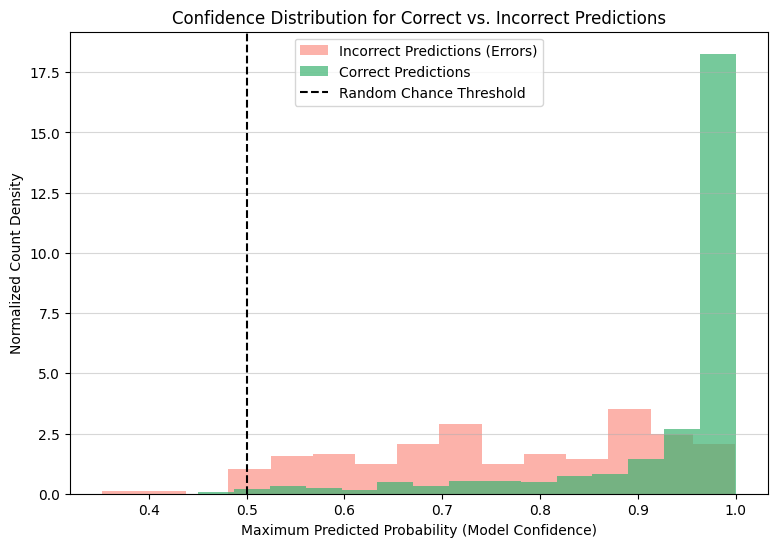

In [63]:
# --- Plotting Confidence Distribution ---

# 1. Calculate the 'is_correct' flag
predictions['is_correct'] = (predictions['predicted_index'] == predictions['label'])

# 2. Filter the confidence scores based on correctness
correct_confidences = predictions[predictions['is_correct']]['max_confidence']
incorrect_confidences = predictions[~predictions['is_correct']]['max_confidence']

plt.figure(figsize=(9, 6))

# 3. Plot the distribution of confidence for INCORRECT predictions (should be spread out)
plt.hist(incorrect_confidences, bins=15, alpha=0.6, label='Incorrect Predictions (Errors)', color='salmon', density=True)

# 4. Plot the distribution of confidence for CORRECT predictions (should be clustered at 1.0)
plt.hist(correct_confidences, bins=15, alpha=0.7, label='Correct Predictions', color='mediumseagreen', density=True)


plt.axvline(x=0.5, color='black', linestyle='--', linewidth=1.5, label='Random Chance Threshold')
plt.title('Confidence Distribution for Correct vs. Incorrect Predictions')
plt.xlabel('Maximum Predicted Probability (Model Confidence)')
plt.ylabel('Normalized Count Density')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

In [64]:
mean_residual = np.mean(predictions['classification_residual'])

print(f"Mean Prediction Residual (Bias): {mean_residual:.4f}")

Mean Prediction Residual (Bias): 0.1435


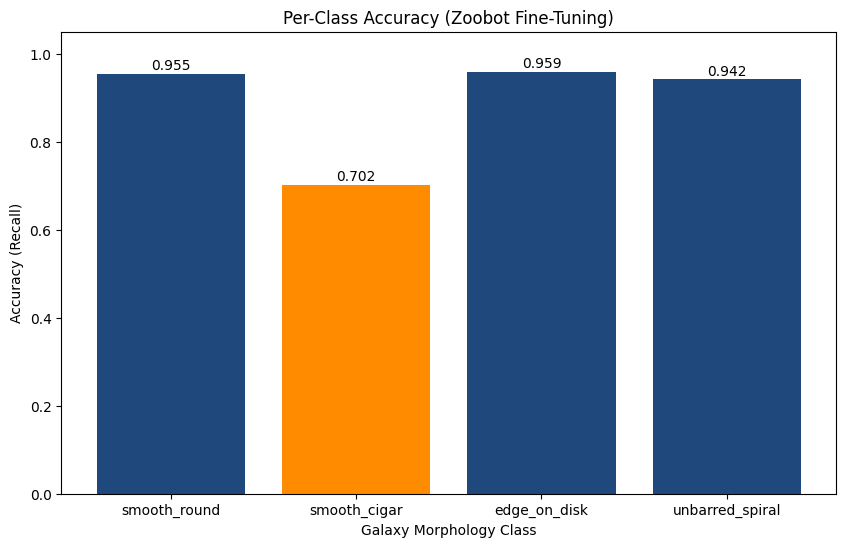

In [72]:
from sklearn.metrics import recall_score # Recall is equivalent to Per-Class Accuracy
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Calculate Per-Class Accuracy (Recall) ---
# We use 'recall_score' which measures how often a class was correctly predicted.
per_class_accuracy = recall_score(
    y_true=predictions_cleaned['label'],
    y_pred=predictions_cleaned['predicted_index'],
    labels=np.arange(len(OFFICIAL_CLASS_ORDER)),
    average=None # Ensure accuracy for each class is returned separately
)

# 2. Create a clean DataFrame for plotting
accuracy_df = pd.DataFrame({
    'Class': OFFICIAL_CLASS_ORDER,
    'Accuracy': per_class_accuracy
})

# 3. Generate the Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(accuracy_df['Class'],
        accuracy_df['Accuracy'],
        color=['#1F497D', '#FF8C00', '#1F497D', '#1F497D'])

# Add the value labels above the bars
for i, acc in enumerate(accuracy_df['Accuracy']):
    plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center')

plt.ylim(0, 1.05)
plt.title('Per-Class Accuracy (Zoobot Fine-Tuning)')
plt.xlabel('Galaxy Morphology Class')
plt.ylabel('Accuracy (Recall)')
plt.show()

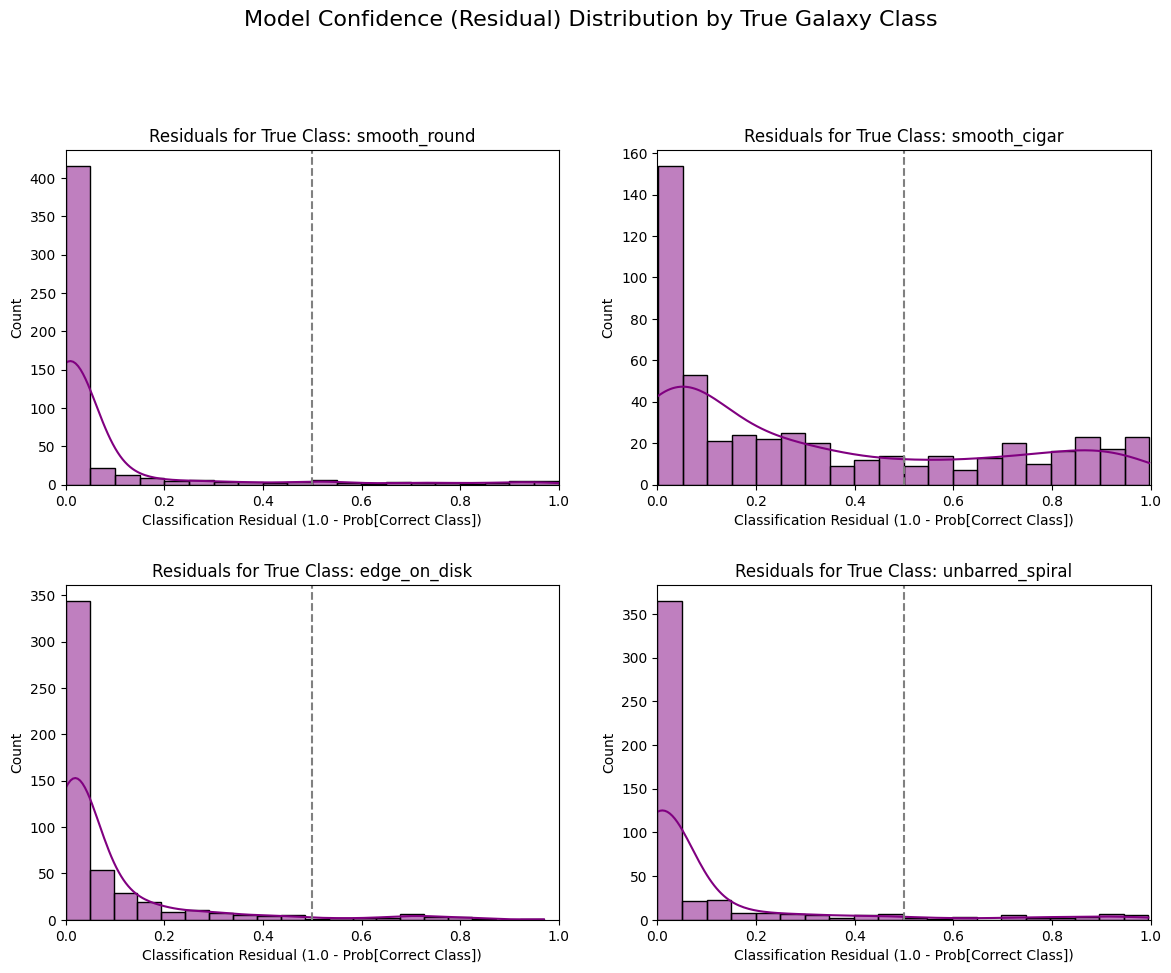

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for easy visualization of distributions

# 1. Prepare the data for plotting
# We use the cleaned predictions for visualization

df_plot = predictions.copy()
df_plot = df_plot[df_plot['predicted_index'].notna()].copy()

# 2. Setup the plot area
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
plt.subplots_adjust(hspace=0.3)
axes = axes.flatten() # Flattens the 2x2 grid into a single array for easier indexing

# 3. Iterate through each class and plot its residual distribution
#OFFICIAL_CLASS_ORDER = ["smooth_round", "smooth_cigar", "edge_on_disk", "unbarred_spiral"]

for i, class_name in enumerate(OFFICIAL_CLASS_ORDER):

    # Filter the residuals for the current class
    residuals_for_class = df_plot[df_plot['true_name_str'] == class_name]['classification_residual']

    # Plot the histogram (KDE adds a smooth density estimate line)
    sns.histplot(
        residuals_for_class,
        bins=20,
        ax=axes[i],
        kde=True,
        color='purple'
    )

    # Add title and labels
    axes[i].set_title(f"Residuals for True Class: {class_name}", fontsize=12)
    axes[i].set_xlabel("Classification Residual (1.0 - Prob[Correct Class])")
    axes[i].set_xlim(0, 1.0)

    # Add a vertical line at 0.5 (random chance threshold if probability error were 0.5)
    axes[i].axvline(0.5, color='gray', linestyle='--')

plt.suptitle("Model Confidence (Residual) Distribution by True Galaxy Class", fontsize=16, y=1.02)
plt.show()

### Data Citation and Source

The **GalaxyMNIST** dataset used in this project is sourced from the **Galaxy Zoo DECaLS** catalogue. Please cite the following paper for the detailed visual morphology measurements:

**Reference (APA Style):**

Walmsley, M., Lintott, C., Géron, T., Kruk, S., Krawczyk, C., Willett, K. W., Bamford, S., Kelvin, L. S., Fortson, L., Gal, Y., Keel, W., Masters, K. L., Mehta, V., Simmons, B. D., Smethurst, R., Smith, L., Baeten, E. M., & Macmillan, C. (2022). Galaxy Zoo DECaLS: Detailed visual morphology measurements from volunteers and deep learning for 314 000 galaxies. *Monthly Notices of the Royal Astronomical Society*, *509*(3), 3966–3985. **DOI: 10.1093/mnras/stab3140**

**ADS Link:** [https://ui.adsabs.harvard.edu/abs/2022MNRAS.509.3966W/abstract](https://ui.adsabs.harvard.edu/abs/2022MNRAS.509.3966W/abstract)